In [22]:
# from https://gitlab.com/dean.rance/collective-behaviour-neuralODEs/-/blob/master/NeuralODEs-boids.ipynb

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint_adjoint as odeint
import matplotlib.pyplot as plt
from IPython.display import clear_output
device = 'cpu'

from scipy.integrate import solve_ivp  # has the same (t,y) order as `odeint` in `torchdiffeq`
from scipy.stats import norm  # too lazy to write out hte pdf

# helpful functions
def euclidean_distance(x1,x2):
    """Too far, too close, just right... these distances need a metric."""
    return np.sqrt(np.sum((x1-x2)**2))

def f_approach(x_focal, x_neighbour):
    """If individuals get too far from each other,
    they will move together with this strength.
    """
    return norm.pdf(
        euclidean_distance(x_focal, x_neighbour),
        loc=4., scale=1.)

def f_avoid(x_focal, x_neighbour):
    """If individuals get too close to each other,
    they will move apart with this strength.
    """
    return norm.pdf(
        euclidean_distance(x_focal, x_neighbour),
        loc=0., scale=1.)

def f_align(x_focal, x_neighbour):
    """If individuals are the correct distance enough to each other,
    they will align with this strength.
    """
    return norm.pdf(
        euclidean_distance(x_focal, x_neighbour),
        loc=2., scale=1.)

def f_centralpull(x_focal): #rather: central push?
    """This stops the individuals from running/flying/swimming away."""
    return np.sum(x_focal**2)

def f_centralpush(x_focal): #fish like boundaries
    """This stops the individuals from running/flying/swimming away."""
    return -np.sum(x_focal**2) 


Rarena= 10.
def f_boundarypush(x_focal):
    r = np.sqrt(np.sum(x_focal**2))
    r_diff = Rarena - r
    strength = norm.pdf(r_diff, loc=4., scale=1.)-2*norm.pdf(r_diff, loc=0., scale=1.)+norm.pdf(r_diff, loc=2., scale=1.)
    if r > Rarena:
        strength -= 3*r
    return strength


def derivative_function(y):
    # t is ignored, so no need to include it here
    positions_and_velocities = y.reshape(4, -1)  # reshape does nothing if the shape is correct already
    derivatives_vectors = np.zeros_like(positions_and_velocities)
    derivatives_vectors[0:2,:] = positions_and_velocities[2:4,:]
    num_individuals = positions_and_velocities.shape[1]

    # TODO: vectorise this
    for focal_idx in range(num_individuals):
        velocity_derivative = np.zeros(2)
        for neighbour_idx in range(num_individuals):
            if focal_idx == neighbour_idx: continue
            vector_direction = positions_and_velocities[:2, neighbour_idx] - positions_and_velocities[:2, focal_idx]
            velocity_derivative += f_approach(
                positions_and_velocities[:2, focal_idx],
                positions_and_velocities[:2, neighbour_idx])*vector_direction
            velocity_derivative -= f_avoid(
                positions_and_velocities[:2, focal_idx],
                positions_and_velocities[:2, neighbour_idx])*vector_direction
            velocity_derivative += f_align(
                positions_and_velocities[:2, focal_idx],
                positions_and_velocities[:2, neighbour_idx])*positions_and_velocities[2:4, neighbour_idx]
        # velocity_derivative += f_centralpush(positions_and_velocities[:2, focal_idx])*positions_and_velocities[:2, focal_idx] #central pull (not so accurate for fish)
        # velocity_derivative += f_centralpull(positions_and_velocities[:2, focal_idx])*positions_and_velocities[:2, focal_idx]
        velocity_derivative += f_boundarypush(positions_and_velocities[:2, focal_idx])*positions_and_velocities[:2, focal_idx]
        derivatives_vectors[2:4, focal_idx] = velocity_derivative
    return derivatives_vectors

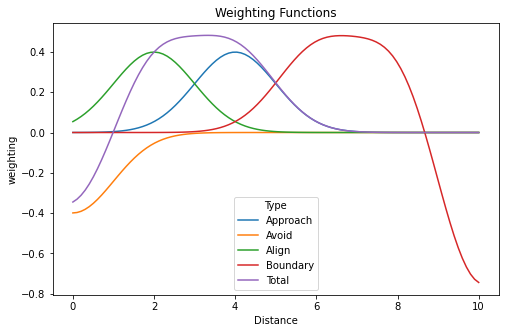

In [45]:
NUMBER_OF_EVAL_POINTS = 100
distances = np.linspace(0, Rarena, NUMBER_OF_EVAL_POINTS)
# target_weights = target_weight(distances)
# other_weights = other_weight(distances)

approachforce = np.array(list(map(f_approach, [0.]*NUMBER_OF_EVAL_POINTS, distances)))
avoidforce = -np.array(list(map(f_avoid, [0.]*NUMBER_OF_EVAL_POINTS, distances)))
alignforce = np.array(list(map(f_align, [0.]*NUMBER_OF_EVAL_POINTS, distances)))
boundaryforce = np.array(list(map(f_boundarypush, distances)))
summedforces = approachforce+avoidforce+alignforce

plt.figure(figsize=(8,5))
plt.plot(distances, approachforce, label='Approach')
plt.plot(distances, avoidforce, label='Avoid')
plt.plot(distances, alignforce, label='Align')
plt.plot(distances, boundaryforce, label='Boundary')
plt.plot(distances, summedforces, label='Total')
plt.xlabel('Distance')
plt.ylabel('weighting')
plt.legend(title='Type')
plt.title('Weighting Functions')
plt.savefig("/home/abel/Documents/GDNDE/figures/collective/weighting_functions.png")
plt.show()

In [46]:
# # pred_y = odeint(derivative_function, y0.to(device), times.to(device)).to(device)
# fig = plt.figure(figsize=(4, 4), facecolor='white')
# ax_vecfield = fig.add_subplot(111, frameon=False)

# ax_vecfield.cla()
# ax_vecfield.set_title('Learned Vector Field')
# ax_vecfield.set_xlabel('x')
# ax_vecfield.set_ylabel('y')
# y, x = np.mgrid[-Rarena-2:Rarena+2:21j, -Rarena-2:Rarena+2:21j]
# dydt = np.zeros((21*21,2))
# for i,position in enumerate(np.stack([x, y], -1).reshape(21 * 21, 2)):
#     dydt[i,:] = f_boundarypush(position)+ f_centralpush( position)
#     # dydt[i,:] =
# mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
# dydt = (dydt / mag)
# dydt = dydt.reshape(21, 21, 2)

# ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")

In [47]:
# initial conditions
NUM_INDIVIDUALS = 7

initial_positions = np.random.randn(4, NUM_INDIVIDUALS)  # rows 0,1 are location; rows 2,3 are velocity#

# the derivative function needs to work with vectors (input and output) and needs a time input
fun = lambda t, y: derivative_function(y).reshape(-1)

START_TIME = 0.
END_TIME = 5.
NUMBER_OF_EVAL_POINTS = 1000

t_span = [START_TIME, END_TIME]
t_eval = np.linspace(t_span[0], t_span[1], NUMBER_OF_EVAL_POINTS)

res = solve_ivp(fun=fun, t_span=t_span, y0=initial_positions.reshape(-1), t_eval=t_eval)

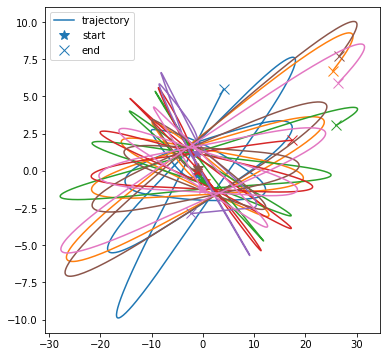

In [48]:
result_reshaped = res.y.reshape(4,NUM_INDIVIDUALS, -1)

fig = plt.figure(figsize=(6,6))

for focal_idx in range(NUM_INDIVIDUALS):
    positions = result_reshaped[:2, focal_idx, :]
    plt.plot(
        positions[0,:], positions[1,:], color=f"C{focal_idx}",
        label='trajectory' if focal_idx==0 else None)
    plt.plot(
        initial_positions[0,focal_idx], initial_positions[1,focal_idx],
        '*', color=f"C{focal_idx}", markersize=10,
        label='start' if focal_idx==0 else None)
    
    plt.plot(
        positions[0,-1], positions[1,-1],
        'x', color=f"C{focal_idx}", markersize=10,
        label='end' if focal_idx==0 else None)
plt.legend()

plt.savefig("/home/abel/Documents/GDNDE/figures/collective/cb_N%s.png"%NUM_INDIVIDUALS)

In [543]:
n_timesteps = NUMBER_OF_EVAL_POINTS
times = torch.tensor(t_eval)

n_boids = NUM_INDIVIDUALS

ys_true = torch.tensor(result_reshaped.T, dtype=torch.float) #time, animal, y=(x,y,v_x,v_y)
positions_true = ys_true[:,:,:2]
y0 = ys_true[0,:,:]
positions0 = y0[:,:2]

ys_true.shape, positions.shape, positions0.shape

(torch.Size([500, 7, 4]), (2, 500), torch.Size([7, 2]))

In [544]:
# Functions to support fitting neural network
batch_size = 16
batch_time = 10

device = 'cpu'


# taken from demo
class RunningAverageMeter:
    """Computes and stores average and current value."""
    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()
    
    def reset(self):
        self.val = None
        self.avg = 0
    
    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1-self.momentum)
        self.val = val  # why do we have self.val? Why not set self.avg to None
        

class ODEFunc(nn.Module):
    """The neural net approximation of the dynamical system."""
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.other_net = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )
        #use target net for center/boundary?
        # self.target_net = nn.Sequential(
        #     nn.Linear(1, 20),
        #     nn.Tanh(),
        #     nn.Linear(20, 1)
        # )
        
        # for m in self.target_net.modules():
        #     if isinstance(m, nn.Linear):
        #         nn.init.normal_(m.weight, mean=0, std=0.1)
        #         nn.init.constant_(m.bias, val=0)  # probably better to just not have a bias
        for m in self.other_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
    
    def forward(self, t, positions):
        if len(positions.shape) == 2:
            # add dimension for batch
            positions = positions.unsqueeze(0)
        derivative_vectors = torch.empty(positions.shape)
        for j in range(n_boids):
            for i in range(n_boids):
                if i==j: continue
                distance_to_other = get_distance(
                    positions[:, j, :], positions[:, i, :]
                )
                direction_to_other = get_direction(
                    positions[:, j, :], positions[:, i, :],
                    distance=distance_to_other
                )
                # print(distance_to_other)
                # if not (distance_to_other + .01 > distance_to_other):
                #     print(positions[:, j, :], positions[:, i, :])
                # print(distance_to_other, direction_to_other)
                weight_other = self.other_net(distance_to_other.unsqueeze(-1).float()) #added conversion to float
                derivative_vectors[:, j, :] += weighted_component(direction_to_other, weight_other)    
        
        return derivative_vectors
    
class ODEFunc(nn.Module):

    def __init__(self, input_size, hidden_size=32):
        super(ODEFunc, self).__init__()
        

        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(), #try relu?
            nn.Linear(hidden_size, input_size),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y) #why would it be better to let it get recurrent?
        # return self.net(y)

def get_distance(focal_location, other_location):
    return np.clip(torch.sqrt(torch.sum((focal_location - other_location)**2, axis=-1)), -Rarena, Rarena)

def get_direction(focal_location, other_location, distance=None):
    if distance is None:
        distance = get_distance(focal_location, other_location)
    direction = other_location - focal_location
    # add extra dimension to guide broadcasting
    direction = direction / distance.unsqueeze(-1)
    # direction[torch.isclose(distance, 0.)] = 0.
    
    return np.clip(direction, -1, 1)

def weighted_component(direction, weight):
    """Combines weight with direction."""
    if len(weight.shape) == len(direction.shape):
        return weight * direction
    # handle the case that probably won't arise
    return weight.unsqueeze(-1) * direction

In [ ]:
import os
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)
        
def visualize_2d(true_y=None, pred_y=None,times=None, drift=None, save=None, title='', xmin=-2., xmax=2., show=False):
    fig = plt.figure(figsize=(6,6))
    # ax_traj = fig.add_subplot(1, 2, 1)
    ax_phase = fig.add_subplot(1, 1, 1)
    if title is not None:
        fig.suptitle(title)
        
    # ax_traj.set_title('Trajectories')
    # ax_traj.set_xlabel('t')
    # ax_traj.set_ylabel('x,y')
    # ax_traj.plot(t.cpu().numpy(), true_y.cpu().detach().numpy()[:, 0, 0], t.cpu().numpy(), true_y.cpu().detach().numpy()[:, 0, 1], 'g-')
    # ax_traj.plot(t.cpu().numpy(), pred_y.cpu().detach().numpy()[:, 0, 0], '--', t.cpu().numpy(), pred_y.cpu().detach().numpy()[:, 0, 1], 'b--')
    # ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
    # ax_traj.set_ylim(xmin, xmax)
    # ax_traj.legend(['Data x(t)', 'Data p(t)', 'NDE x(t)', 'NDE p(t)'])

    ax_phase.set_title('Phase Portrait')
    ax_phase.set_xlabel('x')
    ax_phase.set_ylabel('y')
    ax_phase.plot(true_y[-1,:,0], true_y[-1,:,1], 'r.', label='Data')
    for j in range(n_boids):
        ax_phase.plot(
            true_y[:, j, 0],
            true_y[:, j, 1], 'r', lw=0.1)
    
    #fitted    
    ax_phase.plot(pred_y[-1,:,0], pred_y[-1,:,1], 'k.', label='fitted')
    for j in range(n_boids):
        ax_phase.plot(pred_y[:, j, 0], pred_y[:, j, 1], 'k', lw=0.1)
    # ax_phase.plot(true_y.cpu().detach().numpy()[:, 0, 0], true_y.cpu().detach().numpy()[:, 0, 1], 'g-')
    # ax_phase.plot(pred_y.cpu().detach().numpy()[:, 0, 0], pred_y.cpu().detach().numpy()[:, 0, 1], 'b--')
    ax_phase.set_xlim(xmin, xmax)
    ax_phase.set_ylim(xmin, xmax)

    fig.canvas.draw()
    fig.canvas.flush_events()
    if save is not None:
        plt.savefig(save+'.png', format='png', dpi=400, bbox_inches ='tight', pad_inches = 0.1)
    if show == True:
        plt.show()
        
def get_batch():
    """Retrieves a batch of data for SGD."""
    s = torch.from_numpy(np.random.choice(
        np.arange(n_timesteps - batch_time, dtype=np.int64),  # start anywhere
        batch_size,
        replace=False))
    # batch_positions0 = positions_true[s, :, :]
    batch_positions0 = ys_true[s, :, :]
    batch_times = times[:batch_time]  # assumes timestep sizes are constant...
    batch_positions = torch.stack([ys_true[s + i, :, :] for i in range(batch_time)], dim=0)
    return batch_positions0.to(device), batch_times.to(device), batch_positions.to(device)

# def get_batch():
#     """Retrieves a batch of data for SGD."""
#     s = torch.from_numpy(np.random.choice(
#         np.arange(n_timesteps - batch_time, dtype=np.int64),  # start anywhere
#         batch_size,
#         replace=False))
#     batch_positions0 = positions_true[s, :, :]
#     # batch_positions0 = ys_true[s, :, :]
#     batch_times = times[:batch_time]  # assumes timestep sizes are constant...
# #     batch_t = t[s:s+batch_time]  
#     batch_positions = torch.stack([positions_true[s + i, :, :] for i in range(batch_time)], dim=0)
#     # batch_positions = torch.stack([ys_true[s + i, :, :] for i in range(batch_time)], dim=0)
#     return batch_positions0.to(device), batch_times.to(device), batch_positions.to(device)

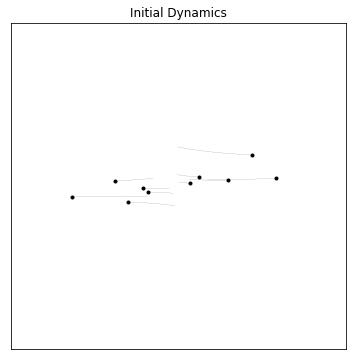

In [238]:
#training with position only
func = ODEFunc(input_size=positions0.shape[1], hidden_size=256)
# initial_dynamics = odeint(func, positions0, times[:2], method='dopri5')
initial_dynamics = odeint(func, positions0, times[:], method='dopri5')
initial_dynamics_transposed = initial_dynamics.permute(1,2,0).detach().numpy()

# fig, axes = plt.subplots(1, 2, figsize=(14,6))
plt.figure(figsize=(6,6))
plt.xlim((-Rarena, Rarena))
plt.ylim((-Rarena, Rarena))
# plt.plot([target[0]], [target[1]], 'rx')
plt.plot(initial_dynamics_transposed[:, 0, -1], initial_dynamics_transposed[:, 1, -1], 'k.')
for j in range(n_boids):
    plt.plot(initial_dynamics_transposed[j, 0, :], initial_dynamics_transposed[j, 1, :], 'k', lw=0.1)
plt.xticks([])
plt.yticks([])
plt.title('Initial Dynamics')
plt.show()

In [239]:
import time
from tqdm.notebook import tqdm

niters = 1000
test_freq = 50

ii = 0
# func = odefunc.to(device)
optimizer = optim.RMSprop(func.parameters(), lr=0.5*1e-3)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

for itr in tqdm(range(0, niters)):
    optimizer.zero_grad()
    batch_pos0, batch_times, batch_pos = get_batch()
    positions_pred = odeint(func, batch_pos0, batch_times, method='dopri5')#.to(device)
    loss = torch.mean(torch.abs(positions_pred - batch_pos))  # Is this the best loss? What about Frechet loss?
    # loss = torch.mean((positions_pred - batch_pos)**2)
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % test_freq == 0:
        with torch.no_grad():
            positions_pred = odeint(func, positions0, times)
            loss = torch.mean(torch.abs(positions_pred - positions_true))
            ii += 1
            # learned_target_weights = func.target_net(distances.unsqueeze(-1))
            # learned_other_weights = func.other_net(distances.unsqueeze(-1))

            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    end = time.time()

  0%|          | 0/1000 [00:00<?, ?it/s]

Iter 0000 | Total Loss 1.827934
Iter 0050 | Total Loss 1.466934
Iter 0100 | Total Loss 1.440696
Iter 0150 | Total Loss 1.413882
Iter 0200 | Total Loss 1.408825
Iter 0250 | Total Loss 1.416664
Iter 0300 | Total Loss 1.418077
Iter 0350 | Total Loss 1.420318
Iter 0400 | Total Loss 1.420420
Iter 0450 | Total Loss 1.418775
Iter 0500 | Total Loss 1.419620
Iter 0550 | Total Loss 1.418467
Iter 0600 | Total Loss 1.419548
Iter 0650 | Total Loss 1.419089
Iter 0700 | Total Loss 1.422023
Iter 0750 | Total Loss 1.418499
Iter 0800 | Total Loss 1.420643
Iter 0850 | Total Loss 1.424094
Iter 0900 | Total Loss 1.417410
Iter 0950 | Total Loss 1.417718


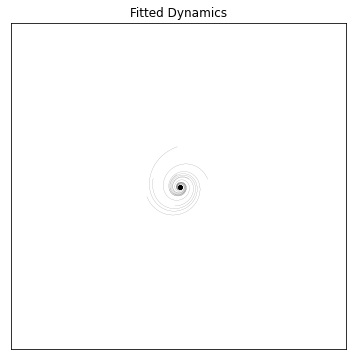

In [240]:
short_times = torch.linspace(0, 2.5, n_timesteps)
with torch.no_grad():
    # dynamics = odeint(func, positions0, times, method='dopri5')
    dynamics = odeint(func, positions0, times, method='dopri5')
    dynamics_transposed = dynamics.permute(1,2,0).detach().numpy()

plt.figure(figsize=(6,6))
plt.xlim((-Rarena, 10.0))
plt.ylim((-Rarena, 10.0))
# plt.plot([target[0]], [target[1]], 'rx')
plt.plot(dynamics_transposed[:, 0, -1], dynamics_transposed[:, 1, -1], 'k.')
for j in range(n_boids):
    plt.plot(dynamics_transposed[j, 0, :], dynamics_transposed[j, 1, :], 'k', lw=0.1)
plt.xticks([])
plt.yticks([])
plt.title('Fitted Dynamics')
plt.show()

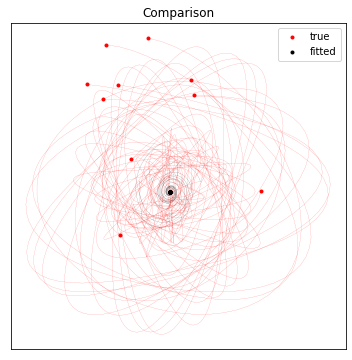

In [242]:
plt.figure(figsize=(6,6))
# positions_true_transposed = positions_true.T
# plt.plot([target[0]], [target[1]], 'rx')
plt.plot(
    positions_true[-1,:,0],
    positions_true[-1,:,1], 'r.', label='true')
for j in range(n_boids):
    plt.plot(
        positions_true[:, j, 0],
        positions_true[:, j, 1], 'r', lw=0.1)
    
#fitted    
plt.plot(dynamics_transposed[:, 0, -1], dynamics_transposed[:, 1, -1], 'k.', label='fitted')
for j in range(n_boids):
    plt.plot(dynamics_transposed[j, 0, :], dynamics_transposed[j, 1, :], 'k', lw=0.1)
plt.legend()
plt.xticks([])
plt.yticks([])
plt.title('Comparison')
plt.show()

In [243]:
# distances = torch.linspace(0, 10, 100)
# target_weights = target_weight(distances)
# other_weights = other_weight(distances)

# with torch.no_grad():
#     learned_target_weights = func.target_net(distances.unsqueeze(-1))
#     learned_other_weights = func.other_net(distances.unsqueeze(-1))

# plt.figure(figsize=(8,5))
# plt.plot(distances, target_weights, 'b', label='target')
# plt.plot(distances, other_weights, 'r', label='other')
# plt.plot(distances, learned_target_weights, 'b:', label='target fitted', lw=4)
# plt.plot(distances, learned_other_weights, 'r:', label='other fitted', lw=4)
# plt.xlabel('distance')
# plt.ylabel('weighting')
# plt.legend(title='type')
# plt.title('Weighting Functions')
# plt.show()

Position and Velocity

In [319]:
#training with position and velocity
hidden_size = 1024
input_size = y0.shape[1]
func = ODEFunc(input_size=input_size, hidden_size=hidden_size)
initial_dynamics = odeint(func, y0, times[:], method='dopri5')
initial_dynamics_transposed = initial_dynamics.permute(1,2,0).detach().numpy()

# # fig, axes = plt.subplots(1, 2, figsize=(14,6))
# plt.figure(figsize=(6,6))
# plt.xlim((-Rarena, Rarena))
# plt.ylim((-Rarena, Rarena))
# # plt.plot([target[0]], [target[1]], 'rx')
# plt.plot(initial_dynamics_transposed[:, 0, -1], initial_dynamics_transposed[:, 1, -1], 'k.')
# for j in range(n_boids):
#     plt.plot(initial_dynamics_transposed[j, 0, :], initial_dynamics_transposed[j, 1, :], 'k', lw=0.1)
# plt.xticks([])
# plt.yticks([])
# plt.title('Initial Dynamics')
# plt.show()

size_folder_name = "figures/collective/"+"/N%s/"%NUM_INDIVIDUALS+"/H%s"%hidden_size
makedirs(size_folder_name)
learning_folder_name = "figures/collective/"+"/N%s/"%NUM_INDIVIDUALS+"/H%s"%hidden_size+"/learning"
makedirs(learning_folder_name)

In [306]:
niters = 1000
test_freq = 50

ii = 0
# func = odefunc.to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

for itr in tqdm(range(0, niters)):
    optimizer.zero_grad()
    batch_pos0, batch_times, batch_pos = get_batch()
    positions_pred = odeint(func, batch_pos0, batch_times, method='dopri5')#.to(device)
    loss = torch.mean(torch.abs(positions_pred - batch_pos))  # Is this the best loss? What about Frechet loss?
    # loss = torch.mean((positions_pred - batch_pos)**2)
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % test_freq == 0:
        with torch.no_grad():
            positions_pred = odeint(func, y0, times)
            loss = torch.mean(torch.abs(positions_pred - ys_true))
            ii += 1
            # learned_target_weights = func.target_net(distances.unsqueeze(-1))
            # learned_other_weights = func.other_net(distances.unsqueeze(-1))
            save_name = learning_folder_name +"/learning_T%s"%itr
            visualize_2d(ys_true, positions_pred, func, ii, title="Training step %s"%itr, save=save_name, xmin=-Rarena, xmax=Rarena)
            plt.close()

            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    end = time.time()

  0%|          | 0/1000 [00:00<?, ?it/s]

Iter 0000 | Total Loss 9.128404
Iter 0050 | Total Loss 8.977866
Iter 0100 | Total Loss 9.046497
Iter 0150 | Total Loss 9.658607
Iter 0200 | Total Loss 10.203450
Iter 0250 | Total Loss 10.095772
Iter 0300 | Total Loss 9.473025
Iter 0350 | Total Loss 9.807036
Iter 0400 | Total Loss 9.156207
Iter 0450 | Total Loss 9.692286
Iter 0500 | Total Loss 9.522079
Iter 0550 | Total Loss 9.085937
Iter 0600 | Total Loss 9.119570
Iter 0650 | Total Loss 9.023895
Iter 0700 | Total Loss 8.854926
Iter 0750 | Total Loss 8.858505
Iter 0800 | Total Loss 8.923577
Iter 0850 | Total Loss 9.306561
Iter 0900 | Total Loss 9.329227
Iter 0950 | Total Loss 9.533828


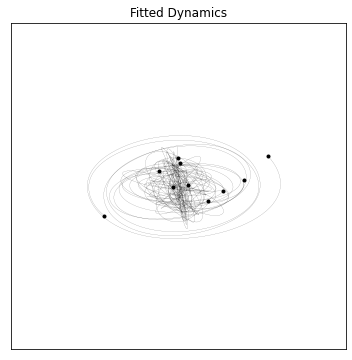

In [307]:
ext_times = torch.linspace(0.,10.,100)
with torch.no_grad():
    # dynamics = odeint(func, positions0, times, method='dopri5')
    dynamics = odeint(func, y0, times, method='dopri5')
    dynamics_transposed = dynamics.permute(1,2,0).detach().numpy()

plt.figure(figsize=(6,6))
plt.xlim((-Rarena, Rarena))
plt.ylim((-Rarena, Rarena))
# plt.plot([target[0]], [target[1]], 'rx')
plt.plot(dynamics_transposed[:, 0, -1], dynamics_transposed[:, 1, -1], 'k.')
for j in range(n_boids):
    plt.plot(dynamics_transposed[j, 0, :], dynamics_transposed[j, 1, :], 'k', lw=0.1)
plt.xticks([])
plt.yticks([])
plt.title('Fitted Dynamics')
plt.show()

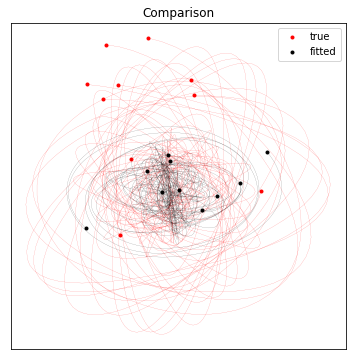

In [308]:
plt.figure(figsize=(6,6))
# positions_true_transposed = positions_true.T
# plt.plot([target[0]], [target[1]], 'rx')
plt.plot(
    positions_true[-1,:,0],
    positions_true[-1,:,1], 'r.', label='true')
for j in range(n_boids):
    plt.plot(
        positions_true[:, j, 0],
        positions_true[:, j, 1], 'r', lw=0.1)
    
#fitted    
plt.plot(dynamics_transposed[:, 0, -1], dynamics_transposed[:, 1, -1], 'k.', label='fitted')
for j in range(n_boids):
    plt.plot(dynamics_transposed[j, 0, :], dynamics_transposed[j, 1, :], 'k', lw=0.1)
plt.legend()
plt.xticks([])
plt.yticks([])
plt.title('Comparison')
plt.show()

In [ ]:
#Latent RNNs

In [316]:
def create_inout_sequences(input_data, tw):
    train_data = []
    labels = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        train_data.append(torch.FloatTensor(train_seq.detach().cpu()).squeeze(1).unsqueeze(0))
        labels.append(torch.FloatTensor(train_label.detach().cpu()).squeeze(1).unsqueeze(0))

    return torch.cat(train_data, 0), torch.cat(labels, 0)


class fcRNN(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, n_layers):
        super(fcRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, 
                          hidden_dim, n_layers, 
                          nonlinearity='relu',
                          batch_first=True) # RNN hidden units
        self.fc = nn.Linear(hidden_dim, output_size) # output layer

    # def forward(self, t, y):
    #     return self.fc(self.rnn(y))     
        
    def forward(self, x):
        bs, _, _ = x.shape
        h0 = torch.zeros(self.n_layers, bs, self.hidden_dim).requires_grad_().to(device)
        out, hidden = self.rnn(x, h0.detach())
        out = out.view(bs, -1, self.hidden_dim)
        out = self.fc(out)
        return out[:, -1, :]
    
def model_predict(pred_len, model, initial_condition):
    test_inputs = initial_condition
    pred_traj = []
    for i in range(train_window):
        pred_traj.append(test_inputs[i])

    with torch.no_grad():
        for i in range(pred_len):
            seq = torch.tensor(np.array(pred_traj).squeeze()[-train_window:])
            model_out = model(seq.unsqueeze(0)).squeeze().detach().numpy().reshape(-1)
            pred_traj.append(model_out)
    pred_traj = np.array(pred_traj)
    return pred_traj

In [376]:
input_size = 40
hidden_size = 1000
n_depth = 2
model = fcRNN(input_size, hidden_size, input_size, n_depth).to(device)
ys_true_flat = ys_true.reshape((ys_true.shape[0],1,-1))

size_folder_name = "figures/collective/"+"/N%s/"%NUM_INDIVIDUALS+"/H%s"%hidden_size
learning_folder_name = "figures/collective/"+"/N%s/"%NUM_INDIVIDUALS+"/H%s"%hidden_size+"/Flearning"
makedirs(learning_folder_name)

In [377]:
train_window = 20
# generating training data and labels for RNN
data_train, labels = create_inout_sequences(ys_true_flat, train_window)
data_train.shape
epochs = 3000
loss_arr = []
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# training loop
for itr in range(epochs):
    if itr > 1500:
        optimizer.param_groups[0]['lr'] = .5*1e-3
    optimizer.zero_grad()
    y_pred = model(data_train)
    #print(y_pred.shape)
    loss = loss_function(y_pred, labels.squeeze())
    loss.backward()
    optimizer.step()
    
    loss_arr.append(loss.item())
    if itr%50 == 0:
        print(f'epoch: {itr:3} loss: {loss_arr[-1]:10.8f}')
        pred_len = 1000
        test_inputs = data_train[0].squeeze().detach().numpy()
        pred_traj = model_predict(pred_len, model, test_inputs)
        save_name = learning_folder_name +"/learning_T%s"%itr
        positions_pred = pred_traj.reshape((pred_traj.shape[0], n_boids, -1))[:,:,:2]
        visualize_2d(ys_true, positions_pred, func, ii, title="Training step %s"%itr, save=save_name, xmin=-Rarena, xmax=Rarena)
        plt.close()

print(f'epoch: {itr:3} loss: {loss_arr[-1]:10.10f}')

epoch:   0 loss: 434.86215210
epoch:  50 loss: 50.67284393
epoch: 100 loss: 12.97063255
epoch: 150 loss: 3.62721944
epoch: 200 loss: 1.41543365
epoch: 250 loss: 0.85486311
epoch: 300 loss: 0.70899028
epoch: 350 loss: 0.30906129
epoch: 400 loss: 0.43514276
epoch: 450 loss: 0.13331553
epoch: 500 loss: 0.32199767
epoch: 550 loss: 0.07881922
epoch: 600 loss: 0.70067465
epoch: 650 loss: 0.05527463
epoch: 700 loss: 0.16631834
epoch: 750 loss: 0.03755819
epoch: 800 loss: 0.03032760
epoch: 850 loss: 0.06000485
epoch: 900 loss: 0.02473759
epoch: 950 loss: 0.02155675
epoch: 1000 loss: 0.03549991
epoch: 1050 loss: 0.01678047
epoch: 1100 loss: 0.19529411
epoch: 1150 loss: 0.61865902
epoch: 1200 loss: 0.01477892
epoch: 1250 loss: 0.19396140
epoch: 1300 loss: 0.01209867
epoch: 1350 loss: 0.12729782
epoch: 1400 loss: 0.01012823
epoch: 1450 loss: 0.21281143
epoch: 1500 loss: 0.01016466
epoch: 1550 loss: 0.00813102
epoch: 1600 loss: 0.00762166
epoch: 1650 loss: 0.00720807
epoch: 1700 loss: 0.00684702
e

In [378]:
pred_len = 1000
test_inputs = data_train[0].squeeze().detach().numpy()
pred_traj = model_predict(pred_len, model, test_inputs)
positions_pred = pred_traj.reshape((pred_traj.shape[0], n_boids, -1))[:,:,:2]

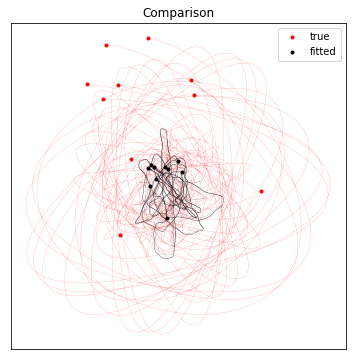

In [379]:
plt.figure(figsize=(6,6))
# positions_true_transposed = positions_true.T
# plt.plot([target[0]], [target[1]], 'rx')
plt.plot(
    positions_true[-1,:,0],
    positions_true[-1,:,1], 'r.', label='true')
for j in range(n_boids):
    plt.plot(
        positions_true[:, j, 0],
        positions_true[:, j, 1], 'r', lw=0.1)
    
#fitted    
plt.plot(positions_pred[-1,:,0], positions_pred[-1,:,1], 'k.', label='fitted')
for j in range(n_boids):
    plt.plot(positions_pred[:, j, 0], positions_pred[:, j, 1], 'k', lw=0.1)
plt.legend()
plt.xticks([])
plt.yticks([])
plt.title('Comparison')
plt.savefig(size_folder_name+"/both_trajectories.png")
plt.show()

In [380]:
import glob
from PIL import Image, ImageDraw

frames = []
imgs = sorted(glob.glob(learning_folder_name+"/*.png"))
imgs = sorted(imgs, key = lambda x: int(x[50:-4]))
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
    
frames[0].save(size_folder_name+'/fnn_traning%s.gif'%hidden_size, format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

ValueError: invalid literal for int() with base 10: 'T0'

In [571]:
class fcRNN(nn.Module):
    #latent RNN 
    def __init__(self, input_size, hidden_dim, output_size, n_layers):
        super(fcRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, 
                          hidden_dim, n_layers, 
                          nonlinearity='relu',
                          batch_first=True) # RNN hidden units
        self.fc = nn.Linear(hidden_dim, output_size) # output layer

    # def forward(self, t, y):
    #     return self.fc(self.rnn(y))     
        
    def forward(self, x):
        batch_size, _, _ = x.shape
        h0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).requires_grad_().to(device)
        out, hidden = self.rnn(x, h0.detach())
        out = out.view(batch_size, -1, self.hidden_dim)
        out = self.fc(out)
        return out[:, -1, :]
    
    
def create_inout_sequences(input_data, tw):
    train_data = []
    labels = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        train_data.append(torch.FloatTensor(train_seq.detach().cpu()).squeeze(1).unsqueeze(0))
        labels.append(torch.FloatTensor(train_label.detach().cpu()).squeeze(1).unsqueeze(0))

    return torch.cat(train_data, 0), torch.cat(labels, 0)


def create_batchio_sequences(ys, train_window=10):
    # ys.shape = (Time, batch, input dimension)
    batch_size = ys.shape[1]
    input_size = ys.shape[2]
    data_train_r = torch.empty((0,train_window,input_size))
    labels_r = torch.empty((0,1,input_size))
    for i in range(batch_size):
        data_train_i, labels_i = create_inout_sequences(ys[:,i,:], train_window)
        data_train_r = torch.cat((data_train_r, data_train_i))
        labels_r = torch.cat((labels_r, labels_i))
    return data_train_r, labels_r

In [572]:
folder_name = "figures/collective/boids/N%s"%NUM_INDIVIDUALS
makedirs(folder_name)

In [608]:
# ys = res.y.reshape(-1 ,1,NUM_INDIVIDUALS*4)
positions = result_reshaped[:2, :, :].T.reshape(-1, 1, NUM_INDIVIDUALS*2) #result_reshaped.T.shape=(Time, NUM_INDIV, 4)
true_y = torch.tensor(positions, dtype=torch.float)
t = torch.tensor(t_eval)

train_window = 10
# generating training data and labels for RNN from grid batch
data_train_r, labels_r = create_batchio_sequences(true_y, train_window)
data_train_r.shape, labels_r.shape

(torch.Size([990, 10, 14]), torch.Size([990, 1, 14]))

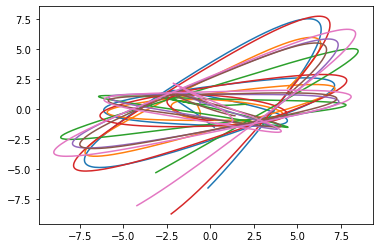

In [609]:

for i in range(NUM_INDIVIDUALS):
    posi = true_y[:,0,:].reshape(-1, NUM_INDIVIDUALS, 2)[:,i,:]
    plt.plot(posi[:,0], posi[:,1])

In [610]:
#learning with latent RNN
hidden_size = 100
size_folder_name = folder_name+"/N%s/"%hidden_size
learning_folder_name = folder_name+"/N%s/"%hidden_size+"/Flearning/"
makedirs(learning_folder_name)

feature_size = true_y.shape[2]
model = fcRNN(feature_size, hidden_size, feature_size, 2).to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters())
print("Model has a total of {0} parameters.".format(pytorch_total_params))

Model has a total of 33214 parameters.


In [632]:
pred_len = true_y.shape[0]-train_window
epochs = 10501
test_freq = 50
loss_arr = []
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
ii = 0
# for itr in tqdm(range(epochs)):
for itr in tqdm(range(10001, epochs)):
    if itr > 2000:
        optimizer.param_groups[0]['lr'] = 1e-5
    optimizer.zero_grad()
    y_pred = model(data_train_r)
    loss = loss_function(y_pred, labels_r.squeeze())
    loss.backward()
    optimizer.step()
    
    loss_arr.append(loss.item())
    if itr % test_freq == 0:
        print(f'epoch: {itr:3} loss: {loss_arr[-1]:10.8f}')

        test_inputs = data_train_r[0].squeeze().detach().numpy()
        pred_traj = model_predict(pred_len, model, test_inputs)

        save_name = learning_folder_name +"/learning_T%s"%itr

        visualize_2d(true_y.reshape((-1,NUM_INDIVIDUALS,2)), torch.tensor(pred_traj).reshape((-1,NUM_INDIVIDUALS,2)), t, title="Training step %s"%itr, save=save_name, xmin=-10., xmax=10.)
        plt.close()
        ii += 1

print(f'epoch: {itr:3} loss: {loss_arr[-1]:10.10f}')

  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 10050 loss: 0.00000674
epoch: 10100 loss: 0.00000668
epoch: 10150 loss: 0.00000667
epoch: 10200 loss: 0.00000666
epoch: 10250 loss: 0.00000665
epoch: 10300 loss: 0.00000663
epoch: 10350 loss: 0.00000662
epoch: 10400 loss: 0.00000660
epoch: 10450 loss: 0.00000659
epoch: 10500 loss: 0.00000662
epoch: 10500 loss: 0.0000066167


In [597]:
test_inputs.shape

(20, 40)

In [634]:
pred_len = 1000
test_inputs = data_train_r[0].squeeze().detach().numpy()
pred_traj = model_predict(pred_len, model, test_inputs)
positions_pred = pred_traj.reshape((pred_traj.shape[0], n_boids, -1))

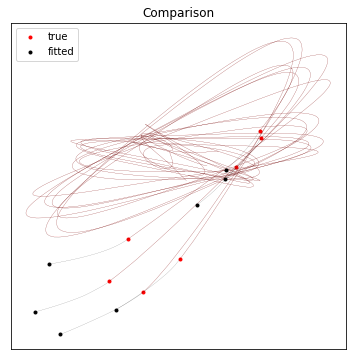

In [635]:
plt.figure(figsize=(6,6))
# positions_true_transposed = positions_true.T
# plt.plot([target[0]], [target[1]], 'rx')
plt.plot(
    positions.reshape((positions.shape[0], NUM_INDIVIDUALS, 2))[-1,:,0],
    positions.reshape((positions.shape[0], NUM_INDIVIDUALS, 2))[-1,:,1], 'r.', label='true')
for j in range(n_boids):
    plt.plot(
        positions.reshape((positions.shape[0], NUM_INDIVIDUALS, 2))[:, j, 0],
        positions.reshape((positions.shape[0], NUM_INDIVIDUALS, 2))[:, j, 1], 'r', lw=0.1)
    
#fitted    
plt.plot(positions_pred[-1,:,0], positions_pred[-1,:,1], 'k.', label='fitted')
for j in range(n_boids):
    plt.plot(positions_pred[:, j, 0], positions_pred[:, j, 1], 'k', lw=0.1)
plt.legend()
plt.xticks([])
plt.yticks([])
plt.title('Comparison')
plt.savefig(size_folder_name+"/trainpredict_trajectories.png")
plt.show()

In [644]:
frames = []
imgs = sorted(glob.glob(learning_folder_name + "/*.png"))
shift_index = 
imgs = sorted(imgs, key = lambda x: int(x[54:-4]))
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
    
frames[0].save(folder_name+"/N%s/"%hidden_size+'training_rnn%s.gif'%hidden_size, format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

In [651]:
# TESTING the model
#new init positions + velocities
initial_positions_test = np.random.randn(4, NUM_INDIVIDUALS)  # rows 0,1 are location; rows 2,3 are velocity#
res_test = solve_ivp(fun=fun, t_span=t_span, y0=initial_positions_test.reshape(-1), t_eval=t_eval)

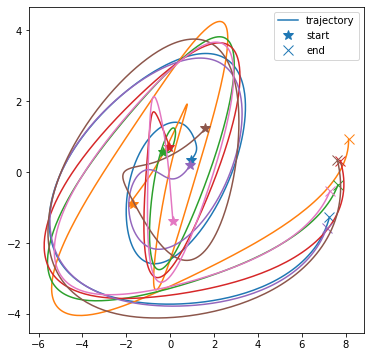

In [653]:
#plot test data
result_test_reshaped = res_test.y.reshape(4,NUM_INDIVIDUALS, -1)

fig = plt.figure(figsize=(6,6))

for focal_idx in range(NUM_INDIVIDUALS):
    positions = result_test_reshaped[:2, focal_idx, :]
    plt.plot(
        positions[0,:], positions[1,:], color=f"C{focal_idx}",
        label='trajectory' if focal_idx==0 else None)
    plt.plot(
        initial_positions_test[0,focal_idx], initial_positions_test[1,focal_idx],
        '*', color=f"C{focal_idx}", markersize=10,
        label='start' if focal_idx==0 else None)
    
    plt.plot(
        positions[0,-1], positions[1,-1],
        'x', color=f"C{focal_idx}", markersize=10,
        label='end' if focal_idx==0 else None)
plt.legend()

plt.savefig(folder_name+"/cb_test_N%s.png"%NUM_INDIVIDUALS)

In [673]:
positions_test = torch.tensor(result_test_reshaped[:2, :, :].T.reshape(-1, 1, NUM_INDIVIDUALS*2), dtype=torch.float) #result_reshaped.T.shape=(Time, NUM_INDIV, 4)


data_test_r, labels_test_r = create_batchio_sequences(positions_test, train_window)

In [675]:
#run model with test data 
pred_len = 1000
test_inputs = data_test_r[0].squeeze().detach().numpy()
pred_traj = model_predict(pred_len, model, test_inputs)
positions_pred = pred_traj.reshape((pred_traj.shape[0], n_boids, -1))

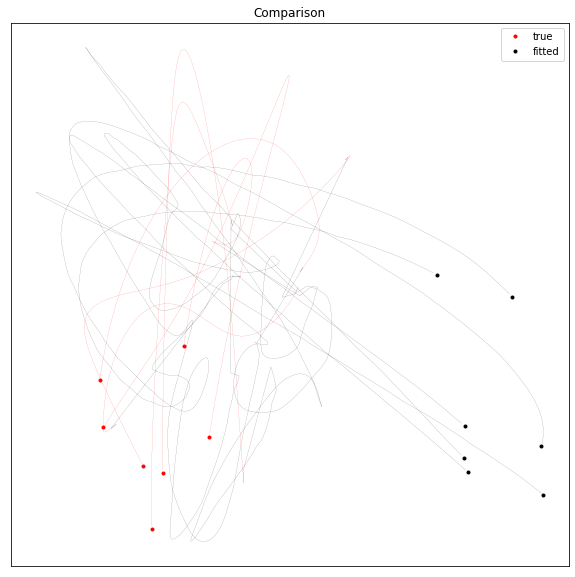

In [682]:
plt.figure(figsize=(10,10))
maxtimeplot = 500
plt.plot(
    positions_test.reshape((positions_test.shape[0], NUM_INDIVIDUALS, 2))[maxtimeplot,:,0],
    positions_test.reshape((positions_test.shape[0], NUM_INDIVIDUALS, 2))[maxtimeplot,:,1], 'r.', label='true')
for j in range(n_boids):
    plt.plot(
        positions_test.reshape((positions_test.shape[0], NUM_INDIVIDUALS, 2))[:maxtimeplot, j, 0],
        positions_test.reshape((positions_test.shape[0], NUM_INDIVIDUALS, 2))[:maxtimeplot, j, 1], 'r', lw=0.1)
    
#fitted    
plt.plot(positions_pred[maxtimeplot,:,0], positions_pred[maxtimeplot,:,1], 'k.', label='fitted')
for j in range(n_boids):
    plt.plot(positions_pred[:maxtimeplot, j, 0], positions_pred[:maxtimeplot, j, 1], 'k', lw=0.1)
plt.legend()
plt.xticks([])
plt.yticks([])
plt.title('Comparison')
plt.savefig(size_folder_name+"/testpredict_trajectories.png")
plt.show()